# Instacart Product Recommender
**Michael Feeley**  
**Metis Bootcamp - Project 4**

**===================================================================================================================**

# Preprocessing

**===================================================================================================================**

### -----------------------

## Load Data

### -----------------------

#### Import Modules

In [58]:
# Loading data
import os

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Packing data
import pickle

#### Unpack Data

In [59]:
# The path for the repo
path = path = "/".join(os.getcwd().split('/')[0:-1])

# Aisles
df_aisles = pd.read_csv(f'{path}/data/aisles.csv')

# Departments
df_departments = pd.read_csv(f'{path}/data/departments.csv')

# Details of all customer's prior 30 orders
df_prior = pd.read_csv(f'{path}/data/order_products__prior.csv')

# Training set containing the most recent carts (next order to predict)
df_train = pd.read_csv(f'{path}/data/order_products__train.csv')

# Order information
df_orders = pd.read_csv(f'{path}/data/orders.csv')

# Products
df_products = pd.read_csv(f'{path}/data/products.csv')

#### Merge the order history with order details

In [60]:
# Merge the order history with additional information
df_prior = df_prior.merge(df_orders.drop(columns = ['eval_set']), on = 'order_id')

# Merge training set with additional information
df_train = df_train.merge(df_orders.drop(columns = ['eval_set']), on = 'order_id')

#### Subset train

In [61]:
# Narrow down the scope of the user_id's in the training dataset
df_train = df_train[df_train.user_id <= 5000]

#### Subset prior

In [62]:
# Filter df_prior to include only user_id's that are in df_train
df_prior = df_prior[df_prior['user_id'].isin(df_train['user_id'].unique())]

### -----------------------

## TARGET

### -----------------------

In [63]:
# This will aggregate the dataframe to create a new one with the current cart
current_cart = (df_train.groupby('user_id', as_index = False)
                .agg({'product_id': (lambda x: set(x))})
                .rename(columns = {'product_id': 'current_cart'}))

In [64]:
# Every product ordered for every user
df_user_products = df_prior.groupby(['user_id','product_id'], as_index = False).size().reset_index().drop(columns = [0])

In [65]:
# Merge the user_product dataframe with the current cart for each user
df_ml = df_user_products.merge(current_cart, on = 'user_id')

# Create target variable (product in cart or not in cart)
df_ml['TARGET'] = df_ml.apply(lambda row: row['product_id'] in row['current_cart'], axis = 1).astype(int)

# Drop the current cart
df_ml.drop(columns = ['current_cart'], inplace = True)

In [66]:
def reset_df(df_ml):
    '''
    Resets df_ml to user_id, product_id, and TARGET.
    '''
   
    # Merge the user_product dataframe with the current cart for each user
    df_ml = df_user_products.merge(current_cart, on = 'user_id')

    # Create target variable (product in cart or not in cart)
    df_ml['TARGET'] = df_ml.apply(lambda row: row['product_id'] in row['current_cart'], axis = 1).astype(int)

    # Drop the current cart
    df_ml.drop(columns = ['current_cart'], inplace = True)
    
    # Return the fresh df_ml
    return df_ml

In [67]:
df_ml

,user_id,product_id,TARGET
0,1,196,1
1,1,10258,1
2,1,10326,0
3,1,12427,0
4,1,13032,1
...,...,...,...
198539,4999,45570,0
198540,4999,46979,0
198541,4999,47209,0
198542,4999,49260,0


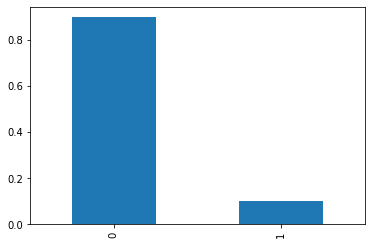

In [68]:
# Get the percentages of each class (relative frequencies)
target_classes = df_ml.TARGET.value_counts(normalize = True)
target_classes.plot(kind = 'bar');

In [69]:
# Create function to plot features for analysis
def plot_features(df, sample_size = 1000):
    
    # Takes a sample of 1000 rows and drops irrelevant data (non-influencing)
    sample = (df.drop(['user_id','product_id'], axis = 1)
                .sample(1000, random_state = 44))
    
    # Pairplot to display any possible class differentiation strength for the feature
    sns.pairplot(sample, hue='TARGET', plot_kws = dict(alpha = .3, edgecolor = 'none'))

### -----------------------

## Feature Engineering

### -----------------------

### User Features:
* **Total Orders**
* **Total Products**
* **Average Cartsize**
* **Average Days Between Orders**

In [70]:
# Create labels
user_feature_labels = ['user_total_prods','user_avg_days_btwn', 'user_total_orders', 'user_avg_cartsize']

# Generate the user features
df_user_features = (df_prior.groupby('user_id', as_index = False)
                    .agg({'product_id':'nunique',
                          'days_since_prior_order':'mean',
                          'order_id':['nunique', lambda x: x.shape[0] / x.nunique()]}))
# Apply labels
df_user_features.columns = ['user_id'] + user_feature_labels

# Add to machine learning dataframe
df_ml = df_ml.merge(df_user_features, on = 'user_id')

# Display
df_ml.head(3)

,user_id,product_id,TARGET,user_total_prods,user_avg_days_btwn,user_total_orders,user_avg_cartsize
0,1,196,1,18,20.259259,10,5.9
1,1,10258,1,18,20.259259,10,5.9
2,1,10326,0,18,20.259259,10,5.9


### Product Features

In [71]:
# Create labels
prod_feature_labels = ['prod_total_orders','prod_avg_cart_pos','prod_avg_hour','prod_avg_day']

# Generate the product features
df_prod_features = (df_prior.groupby('product_id', as_index = False)
                    .agg({'order_id':'count',
                          'add_to_cart_order':'mean',
                          'order_hour_of_day':'mean',
                          'order_dow':'mean'}))

# Label the product features
df_prod_features.columns = ['product_id'] + prod_feature_labels

# Merge
df_ml = df_ml.merge(df_prod_features, on = 'product_id')

### User-Product Features:
* **Total Orders**
* **Average Day**
* **Average Time**
* **Avertage Cart Position**
* **(...)**

In [72]:
# Create the product feature label
user_prod_feature_labels = ['user_prod_total_orders','user_prod_avg_day','user_prod_avg_time','user_prod_avg_cart_position']

# Genrate the product feature
df_user_prod_features = (df_prior.groupby(['user_id','product_id'], as_index = False)
                            .agg({'order_id':'count',
                                  'order_dow':'mean',
                                  'order_hour_of_day':'mean',
                                  'add_to_cart_order':'mean'}))

# Label the product feature
df_user_prod_features.columns = ['user_id','product_id'] + user_prod_feature_labels

# Merge
df_ml = df_ml.merge(df_user_prod_features, on = ['user_id','product_id'])

* **(...)**
* **Order Since Last Ordered**
* **(...)**

In [73]:
# Generate feature labels
cart_info_features = ['cart']

# Generate features
df_cart_info = (df_prior.groupby(['user_id','order_number'], as_index = False)
                .agg({'product_id':(lambda x: list(x))}))

# Label Features
df_cart_info.columns = ['user_id','order_number'] + cart_info_features

# Every cart for each user in sequential order
df_cart_info.head()

,user_id,order_number,cart
0,1,1,"[196, 14084, 12427, 26088, 26405]"
1,1,2,"[196, 10258, 12427, 13176, 26088, 13032]"
2,1,3,"[196, 12427, 10258, 25133, 30450]"
3,1,4,"[196, 12427, 10258, 25133, 26405]"
4,1,5,"[196, 12427, 10258, 25133, 10326, 17122, 41787..."


In [74]:
# Every product ordered for every user, with their latest cart
df_cart_info = df_cart_info.merge(df_user_products, on = 'user_id')
df_cart_info.head()

,user_id,order_number,cart,product_id
0,1,1,"[196, 14084, 12427, 26088, 26405]",196
1,1,1,"[196, 14084, 12427, 26088, 26405]",10258
2,1,1,"[196, 14084, 12427, 26088, 26405]",10326
3,1,1,"[196, 14084, 12427, 26088, 26405]",12427
4,1,1,"[196, 14084, 12427, 26088, 26405]",13032


In [75]:
# Product_in_order indicator
df_cart_info['prod_in_order'] = df_cart_info.apply(lambda x: int (x['product_id'] in x['cart']), axis = 1)
df_cart_info.head()

,user_id,order_number,cart,product_id,prod_in_order
0,1,1,"[196, 14084, 12427, 26088, 26405]",196,1
1,1,1,"[196, 14084, 12427, 26088, 26405]",10258,0
2,1,1,"[196, 14084, 12427, 26088, 26405]",10326,0
3,1,1,"[196, 14084, 12427, 26088, 26405]",12427,1
4,1,1,"[196, 14084, 12427, 26088, 26405]",13032,0


In [76]:
# List of boolean 1's and 0's to indicate each product's presence in each user's order
df_cart_info = (df_cart_info.groupby(['user_id','product_id'], as_index = False)
                .agg({'prod_in_order':lambda x: list(x)}))

df_cart_info.head()

,user_id,product_id,prod_in_order
0,1,196,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,1,10258,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2,1,10326,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3,1,12427,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,1,13032,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 1]"


In [77]:
# How many order since the product was last ordered by the user
df_cart_info['orders_since'] = df_cart_info['prod_in_order'].apply(lambda x: x[::-1].index(1))
df_cart_info.head()

,user_id,product_id,prod_in_order,orders_since
0,1,196,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
1,1,10258,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
2,1,10326,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5
3,1,12427,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
4,1,13032,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 1]",0


In [78]:
# Add the orders_since user_product feature to the dataframe
df_ml = (df_ml.merge(df_cart_info.drop(columns = ['prod_in_order']), on = ['user_id','product_id']))

df_ml.head()

,user_id,product_id,TARGET,user_total_prods,user_avg_days_btwn,user_total_orders,user_avg_cartsize,prod_total_orders,prod_avg_cart_pos,prod_avg_hour,prod_avg_day,user_prod_total_orders,user_prod_avg_day,user_prod_avg_time,user_prod_avg_cart_position,orders_since
0,1,196,1,18,20.259259,10,5.900000,533,3.891182,12.707317,2.765478,10,2.500000,10.300000,1.400000,0
1,21,196,0,102,10.055000,33,6.212121,533,3.891182,12.707317,2.765478,1,3.000000,10.000000,2.000000,23
2,43,196,0,88,10.549296,11,13.363636,533,3.891182,12.707317,2.765478,2,4.000000,14.000000,5.000000,2
3,52,196,0,51,9.134969,27,6.259259,533,3.891182,12.707317,2.765478,14,1.928571,10.071429,4.285714,6
4,67,196,1,23,7.714286,24,3.375000,533,3.891182,12.707317,2.765478,19,1.842105,11.842105,1.421053,1


* **(...)**
* **Order Frequency**

In [79]:
# Divide the total orders with the product by the total orders
df_ml['user_prod_order_freq'] = df_ml.user_prod_total_orders / df_ml.user_total_orders

In [80]:
df_ml.head()

,user_id,product_id,TARGET,user_total_prods,user_avg_days_btwn,user_total_orders,user_avg_cartsize,prod_total_orders,prod_avg_cart_pos,prod_avg_hour,prod_avg_day,user_prod_total_orders,user_prod_avg_day,user_prod_avg_time,user_prod_avg_cart_position,orders_since,user_prod_order_freq
0,1,196,1,18,20.259259,10,5.900000,533,3.891182,12.707317,2.765478,10,2.500000,10.300000,1.400000,0,1.000000
1,21,196,0,102,10.055000,33,6.212121,533,3.891182,12.707317,2.765478,1,3.000000,10.000000,2.000000,23,0.030303
2,43,196,0,88,10.549296,11,13.363636,533,3.891182,12.707317,2.765478,2,4.000000,14.000000,5.000000,2,0.181818
3,52,196,0,51,9.134969,27,6.259259,533,3.891182,12.707317,2.765478,14,1.928571,10.071429,4.285714,6,0.518519
4,67,196,1,23,7.714286,24,3.375000,533,3.891182,12.707317,2.765478,19,1.842105,11.842105,1.421053,1,0.791667


### Packing the Data

In [81]:
with open(f'{path}/pickles/df_ml.pkl', 'wb') as file:
    pickle.dump(df_ml, file)